# Analysis of Data Science Jobs From Indeed.com

## Introduction

Recently, there's been some media hype about how data science is one of the [best fields](https://www.glassdoor.com/List/Best-Jobs-in-America-LST_KQ0,20.htm) to get into. However, because of the [diversity](https://www.datacamp.com/community/tutorials/data-science-industry-infographic#gs.JoXjfNU) of roles in the field, there can be quite a bit of variety in job titles, responsibilities, and qualifications. For people looking to break into data science (like me), there are many factors to consider when job-hunting, but salary is definitely a big one. For this analysis, I built a webscraper to collect data from data science jobs listed on [Indeed](www.indeed.com) in the Boston area. Then, I used a logistic regression model to determine which factors were good predictors of a high salary.

## Methods

### Webscraping

Using the Python library Beautiful Soup, I scraped a unique job ID, job title, and company from 627 job listings. However, the vast majority of job descriptions are not hosted on Indeed.com itself, but require you to navigate to companies' own job pages. To avoid having to scrape each unique company's page, I used Indeed's own search function to find the terms "PhD", "start-up", and "Python", the number of years of experience called for, and whether or not a job paid over $90,000 a year.


In [9]:
from bs4 import BeautifulSoup
from urllib import urlopen
import numpy as np

# initialize lists to store job ID, title, and company
job_ids = []
titles = []
companies = []

# search for all jobs in Boston that pay a minimum of $20,000
# since Indeed displays 10 jobs per page, I'll loop over each page of search results
for i in np.arange(0,1000,10):
    URL = "https://www.indeed.com/jobs?q=data+scientist+$20,000&l=Boston&start={}&pp".format(str(i))
    soup = BeautifulSoup(urlopen(URL).read(), 'html.parser')
    results = soup.find_all('div', attrs={'data-tn-component': 'organicJob'})
    for x in results:
        # get unique job ID
        job_id = x.find('h2', attrs={"class": "jobtitle"})['id']
        job_ids.append(job_id)

        # get company
        company = x.find('span', attrs={"itemprop":"name"}).text.strip()
        companies.append(company)

        # get job title
        title = x.find('a', attrs={'data-tn-element': "jobTitle"}).text.strip()
        titles.append(title)

In [10]:
# Then, take all the lists and combine them into a dataframe
import pandas as pd
jobs = pd.DataFrame(columns = ['job_id','title','company'])
jobs['job_id'] = job_ids
jobs['title'] = titles
jobs['company'] = companies
jobs.head()

,job_id,title,company
0,jl_9a7d42c7e9942208,Data Scientist,DataRobot
1,jl_8fb80761e03f4f34,Computational Scientist,Seven Bridges
2,jl_df3319bfb55ad3cf,Principal Data Scientist (Boston),QuantumBlack
3,jl_1ad7a363fd5d5e05,Research Scientist,AIR Worldwide Corporation
4,jl_04a882314da504d4,"Mass Spectrometry Data Analyst, USA-Boston",Genedata


From the job titles, I'm also interested in whether those described as "analysts" pay less than those described as "scientists", so I'll make columns containing a 0 or 1 if the job contains either term.

In [11]:
# Check titles for Scientist/Analyst descriptions
scientists = []
for i, row in jobs.iterrows():
    title = unicode(row[1])
    if "Scientist" in title:
        scientists.append('1')
    else:
        scientists.append('0')

analysts = []
for i, row in jobs.iterrows():
    title = unicode(row[1])
    if "Analyst" in title:
        analysts.append('1')
    else:
        analysts.append('0')

# Add columns to jobs dataframe        
jobs['analyst_title'] = analysts        
jobs['scientist_title'] = scientists

In [12]:
jobs.head()

,job_id,title,company,analyst_title,scientist_title
0,jl_9a7d42c7e9942208,Data Scientist,DataRobot,0,1
1,jl_8fb80761e03f4f34,Computational Scientist,Seven Bridges,0,1
2,jl_df3319bfb55ad3cf,Principal Data Scientist (Boston),QuantumBlack,0,1
3,jl_1ad7a363fd5d5e05,Research Scientist,AIR Worldwide Corporation,0,1
4,jl_04a882314da504d4,"Mass Spectrometry Data Analyst, USA-Boston",Genedata,1,0


### Creating the dataframe
Using the url's generated from Indeed.com's Advanced Search function for my chosen keywords, I collected the job id's of those that were returned when I searched for "PhD", "start-up", "Python", and for 1,2,3, and 4+ years of experience. I saved these in separate dataframes containing job_id and a column indicating whether or not they had the given attribute. Then, I used an outer merge to combine the two dataframes on the 'job_id' column, and filled any NaN's in the new column with zeroes.

In [ ]:
# Merging the dataframe containing all jobs that called for a PhD
jobs = pd.merge(jobs, phd_df, how = 'outer', on = 'job_id')

The completed dataframe looked something like this:

In [16]:
jobs.head()

,id,Python,over_90k,has_phd,years,has_startup,title,company,scientist_title,analyst_title
0,jl_f43cd8061406b3d7,1.0,1.0,0.0,0,0.0,Director of Data Science and Analysis,Fidelity Investments,0,0
1,jl_90603c7f1f0af480,1.0,1.0,0.0,0,0.0,Analytics Engineer (Boston),QuantumBlack,0,0
2,jl_50022587c7a4a8d9,1.0,1.0,0.0,0,0.0,Data Scientist Intern: Pricing & Profitability...,Wayfair,1,0
3,jl_44da2bd2b0b7e145,1.0,1.0,1.0,0,0.0,Machine Learning Scientist,Amazon Corporate LLC,1,0
4,jl_f5945f64ec7013e3,1.0,1.0,0.0,0,0.0,Data Scientist,MIT,1,0


### Building the model
Since I collected salary data in a binary fashion (greater than $90,000 or not), I'll use a logistic regression to model the relationship between my predictors and salary. Although the year variable could be considered continuous, I'm going to use the number of years (1, 2, 3, or 4+) as categories, since job descriptions probably list just the minimum amount of experience they're asking for anyways.

In [17]:
# Make dummy variables for each year
# X is a matrix of my predictors and y contains the target
import patsy
X = patsy.dmatrix('~C(years) + C(Python) + C(has_phd) + C(has_startup) + C(scientist_title) + C(analyst_title)', jobs)
y = jobs.over_90k

I'll use a cross-validated gridsearch to find the best values of C, the inverse of the regularization parameter lambda, and the penalty. A high C-value means the model uses little regularization and a low C means high regularization. Next, I'll fit the model

In [20]:
# use gridsearch to find best value of C and regularization type to optimize model
from sklearn import linear_model, cross_validation, metrics, grid_search
logreg = linear_model.LogisticRegression()
C_vals = [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]
penalties = ['l1','l2']

gs = grid_search.GridSearchCV(logreg, {'penalty':penalties, 'C':C_vals}, verbose = True, cv = 5, scoring = 'f1_macro')
gs.fit(X, y)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': [0.0001, 0.001, 0.01, 0.1, 0.5, 0.75, 1.0, 2.5, 5.0, 10.0, 100.0, 1000.0]},
       pre_dispatch='2*n_jobs', refit=True, scoring='f1_macro',
       verbose=True)

In [21]:
# Find out the optimized hyperparameter and penalty type for this model
print gs.best_params_

{'penalty': 'l2', 'C': 2.5}


In [23]:
# Fit a model with these hyperparameters and get predictions
gs_logreg = linear_model.LogisticRegression(C = 2.5, penalty = 'l2', solver = 'liblinear')
gs_logreg.fit(X,y)
predictions = gs_logreg.predict(X)

### Evaluate the model

Now that I've fit the model, I'll make a confusion matrix to report the number of false positives and false negatives, as well as the number of jobs it categorized correctly. I'll also print its classification report, which will tell me the precision and recall of the model.

In [27]:
# Make confusion matrix
conmat= metrics.confusion_matrix(y, predictions, labels=gs_logreg.classes_)
conmat= pd.DataFrame(conmat, columns=['Predicted < 90k', 'Predicted > 90k'], index=['Listed < 90k', 'Listed > 90k'])
printconmat

              Predicted < 90k  Predicted > 90k
Listed < 90k              219               92
Listed > 90k              106              210


In [28]:
print metrics.classification_report(y, predictions)

             precision    recall  f1-score   support

        0.0       0.67      0.70      0.69       311
        1.0       0.70      0.66      0.68       316

avg / total       0.68      0.68      0.68       627



From the confusion matrix, I see that the model had 219 true positives and 210 true negatives, which means that it correctly predicted the salary for 429 out of the 627 jobs for an 68% accuracy rate. The precision value reflects the proportion of true positive predictions out of all positive predictions, and the recall reflects the proportion of true positives for a given class. Both have a value of 0.68, meaning the model isn't better at predicting whether a job pays less than $90,000 or more.

### ROC curve

The relative operating characteristic curve is an area under the curve (AUC) graph that illustrates the performance of my logistic regression. The axes on this graph are the true positive rate (or the recall) and false positive rate. For a model that is performing well and has very few false positives for every true positive, the curve will be very steep and the area under the curve will approach 1 for very low false positive rates. However, for a model that yields more false positives, the curve will be less steep, with less area beneath it.

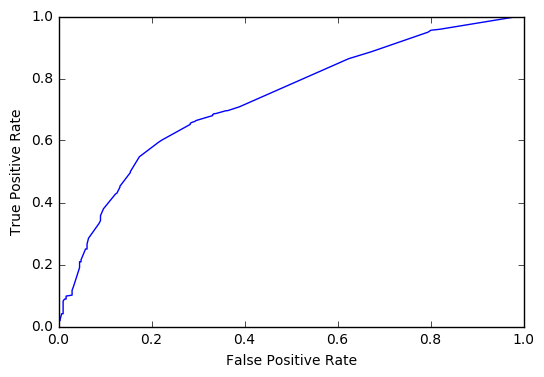

Area under the curve:  0.733668443974


In [52]:
# Plot ROC curve for the job data
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_score = gs_logreg.decision_function(X) 
# decision function calculates the certainty that each job will pay over 90k

FPR, TPR, thresholds = roc_curve(y, y_score)

ROC_AUC = auc(FPR, TPR)

plt.plot(FPR, TPR)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

print "Area under the curve: ", ROC_AUC

### Test the model on new data
Now that I've trained the model on the original 627 jobs I collected and evaluated it, I'll test its performance on new data. Following the same webscraping procedure, I created a new test dataset containing information on 350 new jobs.

In [30]:
# Import dataframe of new jobs and make matrices
testjobs = pd.read_csv('/Users/teresaborcuch/Desktop/test_jobs_clean.csv')
test_X = patsy.dmatrix('~C(years) + C(Python) + C(has_phd) + C(has_startup) + C(scientist_title) + C(analyst_title)', testjobs)
test_y = testjobs.over_90k

In [31]:
# Make predictions for the new values of X
pred_testjobs = gs_logreg.predict(test_X)

In [36]:
# Make confusion matrix for the test jobs
conmat1= metrics.confusion_matrix(test_y, pred_testjobs, labels=gs_logreg.classes_)
conmat1= pd.DataFrame(conmat1, columns=['Predicted < 90k', 'Predicted > 90k'], index=['Listed < 90k', 'Listed > 90k'])
print conmat1

              Predicted < 90k  Predicted > 90k
Listed < 90k              157               78
Listed > 90k                2              113


In [34]:
# Evaluate performance on test set
print metrics.classification_report(test_y, pred_testjobs)

             precision    recall  f1-score   support

        0.0       0.99      0.67      0.80       235
        1.0       0.59      0.98      0.74       115

avg / total       0.86      0.77      0.78       350



The model performed quite well on the new data! It correctly categorized 270 of the 350 jobs for a 77% accuracy rate overall. However, the precision rate for jobs paying over 90k is much worse than the precision rate for jobs paying under 90k, which is reflected in the 78 false positives. These are cases where the model predicted a high salary, but the job actually paid less. The recall value is also less for jobs under 90k, meaning that the model is less accurate for the lower paying jobs.

## Discussion

### Which factor is the best predictor of salary?

To determine which of the variables (keywords "PhD", "Python", or "start-up", years of experience, or having "scientist" vs "analyst" in the job title) had the greatest impact on salary prediction, we have to look at the coefficients of the model.

In [37]:
# Get coefficients
var = ['Intercept',
     'C(years)[T.1]',
     'C(years)[T.2]',
     'C(years)[T.3]',
     'C(years)[T.4]',
     'C(Python)[T.1.0]',
     'C(has_phd)[T.1.0]',
     'C(has_startup)[T.1.0]',
     'C(scientist_title)[T.1]',
     'C(analyst_title)[T.1]']
coef = gs_logreg.coef_[0]
coefs = []
for i in range(0,10):
    coefs.append(coef[i])
model_summary = pd.DataFrame(columns = ['variable','coefficient'])
model_summary['variable'] = var
model_summary['coefficient'] = coefs
model_summary = model_summary.sort_values('coefficient', ascending = False)
model_summary

,variable,coefficient
7,C(has_startup)[T.1.0],1.379817
5,C(Python)[T.1.0],1.322992
4,C(years)[T.4],0.951387
6,C(has_phd)[T.1.0],0.777108
3,C(years)[T.3],0.460874
2,C(years)[T.2],0.003773
8,C(scientist_title)[T.1],-0.174541
0,Intercept,-0.244983
1,C(years)[T.1],-0.712101
9,C(analyst_title)[T.1],-0.797851


Based on these values, jobs that contain "start-up" or "Python" in their descriptions are more likely to pay over \$90,000. We can also see that the more years of experience a job calls for, the more likely it is to pay well, as the 4 years category has a higher coefficient than the three, two, or one year categories. On the other hand, as predicted, jobs that use the title "analyst" are more likely to pay under $90,000 than jobs titled "scientist."

### Reducing False Positives
If I were to apply this model to my job search, I would run the risk of getting my hopes up that a given job paid over \$90,000 a year and then being disappointed when it actually paid less. This happened about 40% of the time on the test data (78 false positives out of 191 total predicted positives). I might decide that it's preferable to have the model that underestimates salary so that I could expect a lower amount, but then be pleasantly surprised when the actual salary was higher. To do this, I could tinker with the probability threshold the model used to determine whether it predicted over 90k. Here, I employed the default of 0.5, but to cut down the number of false positives, I could change it to 0.75. This would mean that the model would predict a salary of over $90,00 for a particular job only if was 75% sure. 

## Conclusions
From this analysis, I've learned that if a particular job uses the terms "start-up" or "Python" in its description, it's more likely to pay over $90,000 than if it doesn't. However, I have to be cautious about concluding that start-ups necessarily pay more. Since the webscraper only returned jobs for which each keyword was mentioned, I don't know the context. A job description explicitly stating that the company is "past its start-up days" would be considered in the same category as a company describing itself as "a small 5-person start-up". 

So if I were using this model in my job search, I'd be optimistic about any jobs mentioning "start-up" or "Python", but cautiously so, given the high false positive rate.

As expected, jobs with "analyst" in the title are less likely to pay over 90k than those with "scientist", and the more years of experience a job calls for, the better the odds that it's high-paying.